# Overview
In this notebook, a Eurepean e-commerce dataset will be explored. Purchase patterns by customers will be visualized and analyzed and potential customer segments will be created using clustering algorithms.
This notebook follows the dataset on Kaggle and procedures in [this wonderful notebook](https://www.kaggle.com/fabiendaniel/customer-segmentation) by F. Daniel.
This notebook is a very basic analysis of the dataset.

## 1: Data Processing and Feature Engineering

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [228]:
data = pd.read_csv("data.csv",encoding="ISO-8859-1")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [229]:
data.isnull().mean() #many missing values in customer, some missing in descriptions

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [230]:
#drop rows with missing customers
data = data[~data["CustomerID"].isna()]
data.isnull().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [231]:
#According to the notebook by F. Daniel, it is also important to check for duplicates and remove them.
data.duplicated().sum()
data.drop_duplicates(inplace = True)

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

In [232]:
data.dtypes #customer id should be a string, date should be a timestamp object

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [233]:
data.loc[:,"CustomerID"] = data["CustomerID"].astype(str)
data.loc[:,"InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

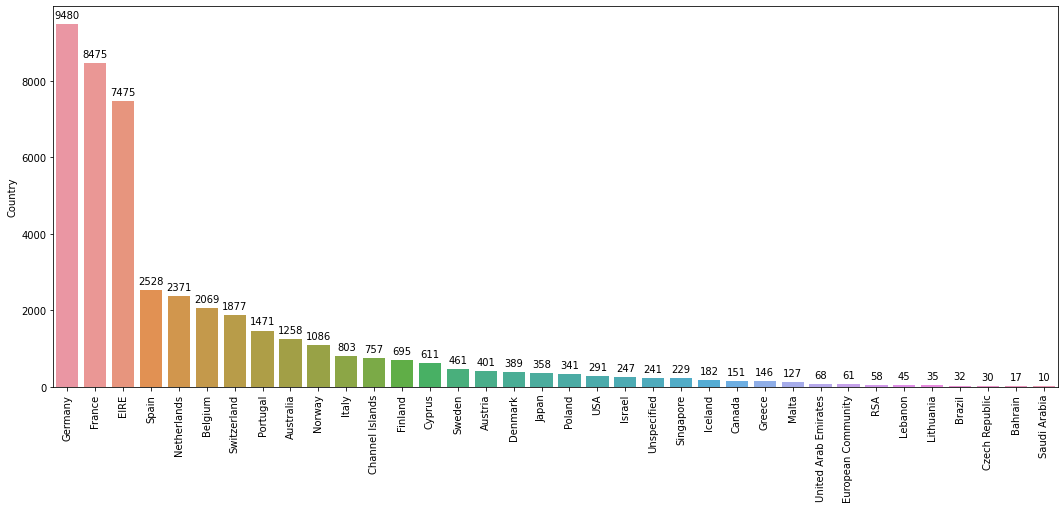

In [234]:
#how many countries except UK, which takes more than 35000 rows: major countries are Germany, France, EIRE
fig = plt.figure(figsize=(18,7))
i = 0.5
g = sns.barplot(data["Country"].value_counts().iloc[1:].index,data["Country"].value_counts().iloc[1:])
for p in g.patches:
    g.annotate(int(p.get_height()), 
    (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

a = plt.xticks(rotation = 90)

In [235]:
#4372 customers, with significanly different purchase frequencies
len(data["CustomerID"].value_counts())

4372

In [236]:
import re #check for special stock codes
data[data["StockCode"].apply(lambda x: not re.search("[0-9]",x) )].groupby("StockCode").agg({"Description":lambda x: x.iloc[0],"Quantity":len})

,Description,Quantity
StockCode,,
BANK CHARGES,Bank Charges,12
CRUK,CRUK Commission,16
D,Discount,77
DOT,DOTCOM POSTAGE,16
M,Manual,460
PADS,PADS TO MATCH ALL CUSHIONS,4
POST,POSTAGE,1196


In [237]:
#add cancelled column, discount column, remove commision and bank charges
data = data[(data["StockCode"]!="CRUK")&(data["StockCode"]!="BANK CHARGES")]
data.loc[:,"cancelled"] = data["InvoiceNo"].str.startswith("C").astype(int)
data.loc[:,"discount_used"] = data["StockCode"].apply(lambda x: x=="D").astype(int)

In [238]:
#cancelled transactions: notices D: discount
canceled = data[data["InvoiceNo"].str.startswith("C")]
canceled.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancelled,discount_used
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,1,0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1,0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,0


There are instances of shorter Stock Code, some corresponds to discounts, bank charges, others seem like uncommon product. There are 1196 rows associated with postage.

In [239]:
canceled.groupby(["InvoiceNo","CustomerID"]).agg(len).shape
#there are 3638 cancelled transactions/invoices after removing abnormal cancellations

(3638, 8)

There are several additional features we can compute based on the existing features, such as the total amount of each row and each transaction by one customer.

In [240]:
#number of products per transaction by customer and invoice
#amount of transaction
#number of cancellation

#total amount each row
data.loc[:,"product_amount"] = data["Quantity"]*data["UnitPrice"]

In [241]:
most_freq_cat(data[data["CustomerID"]=="14911.0"]["Description"])

'CARRIAGE'

In [242]:
#define a function that takes in all unique descriptions a customer bought in a transaction in a list
import nltk
nltk.download('averaged_perceptron_tagger')
import collections

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/simons/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [243]:
#most frequent items
def most_freq_cat(x):
    d = collections.Counter(x)
    sorted_d = dict(sorted(d.items(), key=lambda item: item[1],reverse=True))
    return list(sorted_d.keys())[0]
def most_freq_count(x):
    d = collections.Counter(x)
    sorted_d = dict(sorted(d.items(), key=lambda item: item[1],reverse=True))
    return list(sorted_d.values())[0]

In [244]:
#number of invoices: 22190, same customer with multiple invoices, each time with different purchase quantity
by_inv = data.groupby(["InvoiceNo"]).agg({"CustomerID":lambda x:x.iloc[0],"Description":sum,
                                          "Quantity":sum,"product_amount":sum,"cancelled":lambda x:x.iloc[0],
                                         "discount_used":lambda x:x.iloc[0],
                                        "Country":lambda x:x.iloc[0]}).reset_index()
by_inv.loc[:,"Most Freq Count"] = data["Description"]
by_inv.head()

,InvoiceNo,CustomerID,Description,Quantity,product_amount,cancelled,discount_used,Country,Most Freq Count
0,536365,17850.0,WHITE HANGING HEART T-LIGHT HOLDERWHITE METAL ...,40,139.12,0,0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER
1,536366,17850.0,HAND WARMER UNION JACKHAND WARMER RED POLKA DOT,12,22.20,0,0,United Kingdom,WHITE METAL LANTERN
2,536367,13047.0,ASSORTED COLOUR BIRD ORNAMENTPOPPY'S PLAYHOUSE...,83,278.73,0,0,United Kingdom,CREAM CUPID HEARTS COAT HANGER
3,536368,13047.0,JAM MAKING SET WITH JARSRED COAT RACK PARIS FA...,15,70.05,0,0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE
4,536369,13047.0,BATH BUILDING BLOCK WORD,3,17.85,0,0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.


In [245]:
customer_purchase = by_inv.groupby("CustomerID").agg({"Description":lambda x: most_freq_cat(x),
                                                      "Most Freq Count":lambda x: most_freq_count(x),
                                                      "Quantity":sum,"product_amount":sum,
                                                      "cancelled":sum,"discount_used":sum,"InvoiceNo":len,
                                                     "Country":lambda x:x.iloc[0]}).reset_index()

In [246]:
#customer 14911 has the most number of transactions
#customer = by_inv.groupby("CustomerID").size().sort_values(ascending=False).to_frame().reset_index()
customer = customer_purchase.rename(columns = {"InvoiceNo":"num_invoices","Description":"Most Freq Prod"})
#customer = pd.merge(customer, customer_purchase,on="CustomerID")
customer.loc[:,"amount per invoice"] = customer["product_amount"]/customer["num_invoices"]
customer.sort_values("num_invoices",ascending=False).head()

,CustomerID,Most Freq Prod,Most Freq Count,Quantity,product_amount,cancelled,discount_used,num_invoices,Country,amount per invoice
1895,14911.0,JAM MAKING SET PRINTED,92,77155,132458.73,47,1,248,EIRE,534.107782
330,12748.0,Manual,80,23750,28405.56,14,0,224,United Kingdom,126.810536
4042,17841.0,SKULLS AND CROSSBONES WRAPPOLYESTER FILLER PAD...,65,22628,39869.05,45,0,169,United Kingdom,235.911538
1674,14606.0,HEART DECORATION WITH PEARLS FRENCH ENAMEL POT...,48,5940,11618.35,35,0,127,United Kingdom,91.483071
568,13089.0,REGENCY CAKESTAND 3 TIER,35,30742,57322.13,21,0,118,United Kingdom,485.780763


In [247]:
customer[customer["CustomerID"]=="17850.0"]

,CustomerID,Most Freq Prod,Most Freq Count,Quantity,product_amount,cancelled,discount_used,num_invoices,Country,amount per invoice
4048,17850.0,HAND WARMER RED POLKA DOTHAND WARMER UNION JACK,2,1696,5303.48,1,0,35,United Kingdom,151.528


In [248]:
#37 customers buy Manual most frequently
customer["Most Freq Prod"].value_counts().head(5)

Manual                                37
POSTAGE                               12
REGENCY CAKESTAND 3 TIER               9
JUMBO BAG RED RETROSPOT                6
WHITE HANGING HEART T-LIGHT HOLDER     6
Name: Most Freq Prod, dtype: int64

In [249]:
customer.sort_values("discount_used",ascending=False).head()

,CustomerID,Most Freq Prod,Most Freq Count,Quantity,product_amount,cancelled,discount_used,num_invoices,Country,amount per invoice
1615,14527.0,Discount,36,2048,7709.69,31,28,86,United Kingdom,89.647558
2722,16029.0,Discount,27,33632,53168.69,13,6,76,United Kingdom,699.588026
803,13408.0,CLASSIC GLASS COOKIE JAR,27,16119,27487.41,19,4,81,United Kingdom,339.350741
2329,15498.0,Discount,9,6084,12396.46,8,3,35,United Kingdom,354.184571
3014,16422.0,Manual,23,32592,33805.69,24,3,75,United Kingdom,450.742533


In [250]:
customer.loc[:,"most_freq_count_per_inv"] = customer["Most Freq Count"]/customer["num_invoices"]

Most freq count is the number of items across all invoices, there can be multiple discounts within one invoice, that is why most frequent count is not equal to the number of invoices that use discount. We will use this column for identifying patterns among different customers.

In [251]:
#There are 65 invoices denoting discount
#data[data["Description"]=="Discount"].groupby("InvoiceNo").size()

In [252]:
#word matrix 

## 2. EDA
- Distribution of customers across countries
- Number of invoices across countries
- Discount used across countries
- Distribution of discounts

<AxesSubplot:xlabel='num_invoices'>

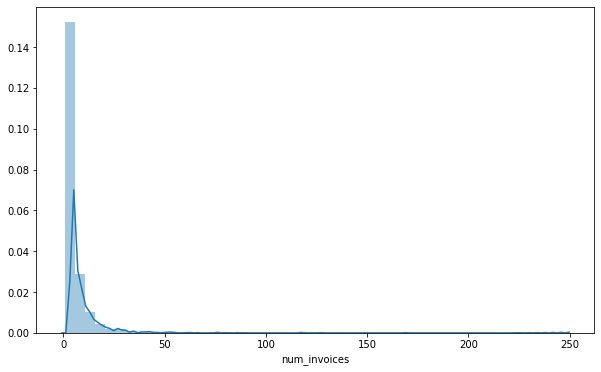

In [253]:
plt.figure(figsize=(10,6))
sns.distplot(customer["num_invoices"])

<AxesSubplot:xlabel='cancelled'>

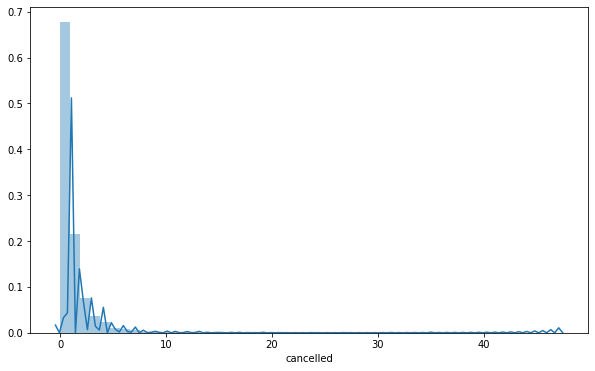

In [254]:
#distribution of cancelled order is skewed
plt.figure(figsize=(10,6))
sns.distplot(customer["cancelled"])

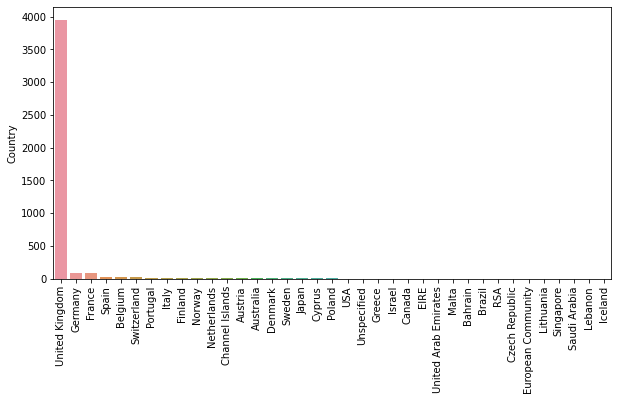

In [255]:
#Most customers from UK
plt.figure(figsize=(10,5))
sns.barplot(customer["Country"].value_counts().index,customer["Country"].value_counts())
a = plt.xticks(rotation=90)

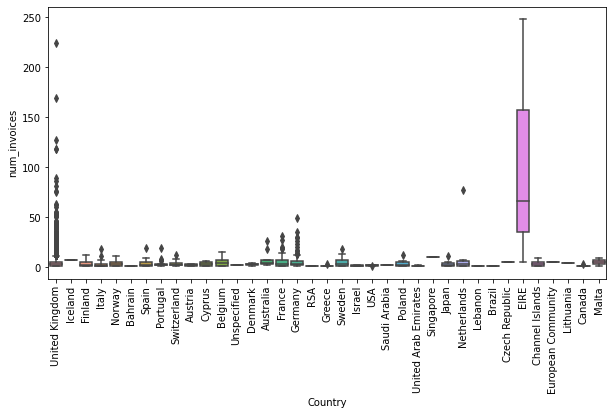

In [256]:
#only 3 data points for customers in EIRE
plt.figure(figsize=(10,5))
sns.boxplot("Country","num_invoices",data=customer)
a = plt.xticks(rotation=90)

In [273]:
customer[customer["Country"]=="EIRE"]

,CustomerID,Most Freq Prod,Most Freq Count,Quantity,product_amount,cancelled,discount_used,num_invoices,Country,amount per invoice,most_freq_count_per_inv,avg cancelled per invoice,avg discount per invoice,cluster
1241,14016.0,JAM JAR WITH PINK LIDJAM JAR WITH GREEN LIDJAM...,1,2124,4328.46,1,0,5,EIRE,865.692000,0.200000,0.200000,0.000000,1
1345,14156.0,BAKING MOULD ROSE WHITE CHOCOLATEBAKING MOULD ...,22,56908,113214.59,11,0,66,EIRE,1715.372576,0.333333,0.166667,0.000000,3
1895,14911.0,JAM MAKING SET PRINTED,92,77155,132458.73,47,1,248,EIRE,534.107782,0.370968,0.189516,0.004032,3


<AxesSubplot:xlabel='num_invoices', ylabel='product_amount'>

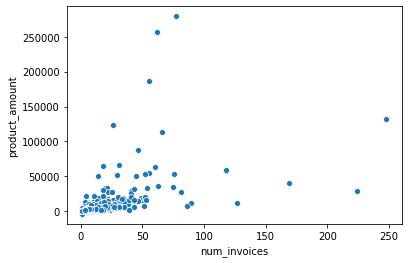

In [270]:
sns.scatterplot(customer["num_invoices"],customer["product_amount"])

### 3. Clustering

In [258]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [261]:
customer.loc[:,"avg cancelled per invoice"] = customer["cancelled"]/customer["num_invoices"]
customer.loc[:,"avg discount per invoice"] = customer["discount_used"]/customer["num_invoices"]
X = customer[["Quantity","avg cancelled per invoice","avg discount per invoice",
             "num_invoices","amount per invoice","most_freq_count_per_inv"]]
s = StandardScaler()
s.fit(X)
X_std = s.transform(X)

In [262]:
X_std

array([[-0.23951649,  2.11458778, -0.05337484, -0.32913496, -0.86535666,
         1.28971469],
       [ 0.28654329, -0.61547293, -0.05337484,  0.20703691,  0.82660183,
        -1.54021352],
       [ 0.26150302, -0.61547293, -0.05337484, -0.11466622,  0.36932944,
        -1.18647249],
       ...,
       [-0.21854258,  1.20456755, -0.05337484, -0.22190059, -0.70359339,
         0.18918705],
       [ 0.05090789, -0.61547293, -0.05337484,  1.17214627, -0.51404194,
        -1.18647249],
       [ 0.09991834, -0.61547293, -0.05337484, -0.22190059,  0.81756758,
        -0.91134059]])

In [276]:
kmeans = KMeans(init='k-means++', n_clusters = 3, n_init=30)
kmeans.fit(X_std)
clusters = kmeans.predict(X_std)


In [277]:
clusters

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [278]:
customer.loc[:,"cluster"] = clusters

<AxesSubplot:xlabel='num_invoices', ylabel='product_amount'>

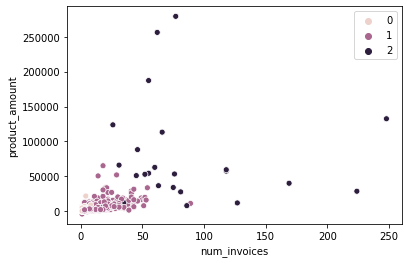

In [283]:
#plot of total dollar amount per transaction vs total number of invoices
sns.scatterplot(customer["num_invoices"],customer["product_amount"],hue = list(customer["cluster"]))

<AxesSubplot:xlabel='avg discount per invoice', ylabel='amount per invoice'>

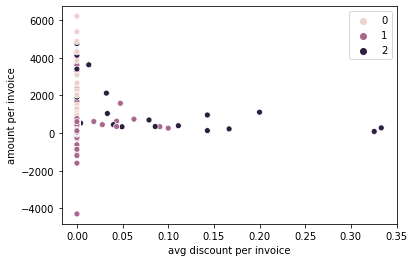

In [284]:
#plot of average amount per invoice vs average discount used per invoice
sns.scatterplot(customer["avg discount per invoice"],customer["amount per invoice"],hue = list(customer["cluster"]))

The analysis of the clusters are not comprehensive, based on the above plots, customers that use discount more frequently are clustered into one group, and customers with larger amount of invoices or larger total spend belong to the same cluster as those who use more discounts. This pattern gives us some basic understanding of out customers. Based on the second scatter plot, those who use more discounts on average not necessarily means larger average amount per invoice, so there are some implicit relationships among those variables. Further work can include choosing the best K, incorporate text analysis by building a matrix representation of the descriptions, so the category of the purchase can be analyzed as well.

#### PCA

In [285]:
from sklearn.decomposition import PCA

In [286]:
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_std)

In [287]:
pca.explained_variance_ratio_

array([0.31783065, 0.22303504, 0.16237673, 0.12410638, 0.11690849,
       0.05574271])

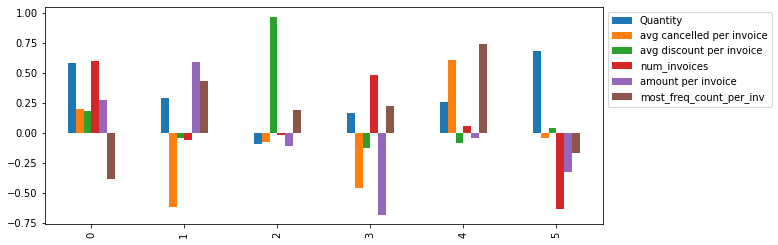

In [289]:
fig,ax=plt.subplots(figsize=(10,4))
pd.DataFrame(pca.components_,columns=X.columns).plot(kind="bar",ax=ax).legend(bbox_to_anchor=(1,1))

The first PC is dominated by Quantity and number of invoices, so this group includes customers who frequently purchase stuff and also likely to buy a number of different goods. The second component is dominated by the average cancellations per customer, with a negative impact. The third PC is dominated by average discounts used. These findings correspond to the patterns found by clustering above.
